In [82]:
import os
import tensorflow as tf
from tensorflow.keras import utils
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [47]:
# location of data
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'

# download the data and extract it
path_to_zip = utils.get_file('cats_and_dogs.zip', origin=_URL, extract=True)

# construct paths
PATH = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')

train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')

# parameters for datasets
BATCH_SIZE = 32
IMG_SIZE = (160, 160)

# construct train and validation datasets 
train_dataset = utils.image_dataset_from_directory(train_dir,
                                                   shuffle=True,
                                                   batch_size=BATCH_SIZE,
                                                   image_size=IMG_SIZE)

validation_dataset = utils.image_dataset_from_directory(validation_dir,
                                                        shuffle=True,
                                                        batch_size=BATCH_SIZE,
                                                        image_size=IMG_SIZE)

# construct the test dataset by taking every 5th observation out of the validation dataset
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)

Found 2000 files belonging to 2 classes.
Found 1000 files belonging to 2 classes.


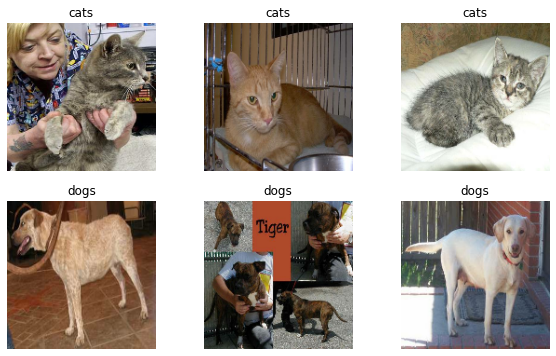

In [48]:
class_names = train_dataset.class_names
plt.figure(figsize= (10, 6))
for images, labels in train_dataset.take(1):
    x = 0
    for i in range(len(images)):
        if(x < 3):
            if(class_names[labels[i]] == "cats"):
                ax = plt.subplot(2, 3, x + 1)
                plt.imshow(images[i].numpy().astype("uint8"))
                plt.title(class_names[labels[i]])
                plt.axis("off")
                x += 1
        if(x >= 3):
            if(class_names[labels[i]] == "dogs"):
                ax = plt.subplot(2, 3, x + 1)
                plt.imshow(images[i].numpy().astype("uint8"))
                plt.title(class_names[labels[i]])
                plt.axis("off")
                x += 1
        if(x >= 6):
            break

In [49]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

In [50]:
labels_iterator= train_dataset.unbatch().map(tf.autograph.experimental.do_not_convert(lambda image, label: label)).as_numpy_iterator()
catcount, dogcount = 0, 0
for x in labels_iterator:
    if x == 0:
        catcount += 1
    else:
        dogcount += 1
print(catcount)
print(dogcount)
#The baseline model would be accurate 50% of the time

1000
1000


In [59]:
num_classes = 2
model1 = tf.keras.Sequential([
    tf.keras.layers.Rescaling(1./255),
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(num_classes)
])

model1.compile(
  optimizer='adam',
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

history1 = model1.fit(train_dataset, 
                     epochs=20, 
                     validation_data=validation_dataset)

Epoch 1/20
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
63/63 [==============================] - ETA: 0s - loss: 0.7079 - accuracy: 0.5470WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x7f972335cef0> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and 

In [ ]:
#My model stabilized between 68-73% accuracy. This is better than the
#baseline of 50% accuracy. However, considering the difference between
#training accuracy(~95%) and validation accuracy(~71%), it is clear
#that overfitting occured with this model.

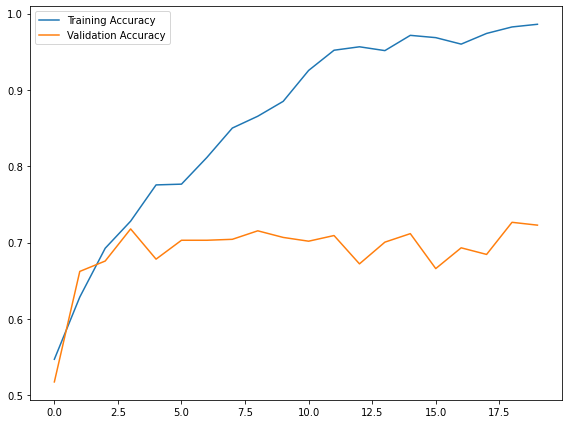

In [88]:
model_history = pd.DataFrame(history1.history)
model_history['epoch'] = history1.epoch
fig, ax = plt.subplots(1, figsize=(8,6))
num_epochs = model_history.shape[0]

ax.plot(np.arange(0, num_epochs), model_history["accuracy"], 
        label="Training Accuracy")
ax.plot(np.arange(0, num_epochs), model_history["val_accuracy"], 
        label="Validation Accuracy")
ax.legend()
plt.tight_layout()
plt.show()

In [85]:
model2 = tf.keras.Sequential([
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.Rescaling(1./255),
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(num_classes)
])
model2.compile(
  optimizer='adam',
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

history2 = model2.fit(train_dataset, 
                     epochs=20, 
                     validation_data=validation_dataset)

Epoch 1/20
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
63/63 [==============================] - ETA: 0s - loss: 0.7368 - accuracy: 0.5270WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x7f972fbddcb0> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and 

In [ ]:
#My model stabilized between 68-73% accuracy. This is
#pretty similar to model1. However, considering the difference between
#training accuracy(~72%) and validation accuracy(~71%), it is clear
#that there was less overfitting with this model.

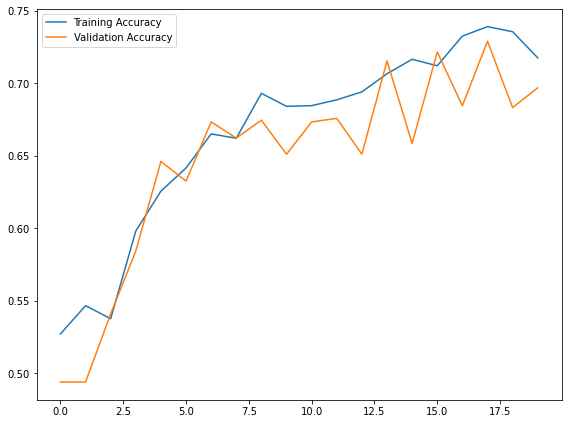

In [89]:
model_history = pd.DataFrame(history2.history)
model_history['epoch'] = history2.epoch
fig, ax = plt.subplots(1, figsize=(8,6))
num_epochs = model_history.shape[0]

ax.plot(np.arange(0, num_epochs), model_history["accuracy"], 
        label="Training Accuracy")
ax.plot(np.arange(0, num_epochs), model_history["val_accuracy"], 
        label="Validation Accuracy")
ax.legend()
plt.tight_layout()
plt.show()

In [90]:
i = tf.keras.Input(shape=(160, 160, 3))
x = tf.keras.applications.mobilenet_v2.preprocess_input(i)
preprocessor = tf.keras.Model(inputs = [i], outputs = [x])

model3 = tf.keras.Sequential([
    preprocessor,
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(0.2),
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(32, 3, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(num_classes)
])
model3.compile(
  optimizer='adam',
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

history3 = model3.fit(train_dataset, 
                     epochs=20, 
                     validation_data=validation_dataset)

Epoch 1/20
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
63/63 [==============================] - ETA: 0s - loss: 0.7449 - accuracy: 0.5535WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x7f972bd27c20> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and 

In [ ]:
#My model stabilized between 72-74% accuracy. This is better than the
#slightly better than model1. Considering the difference between
#training accuracy(~75%) and validation accuracy(~73%), it is clear
#that there was not much overfitting with this model.

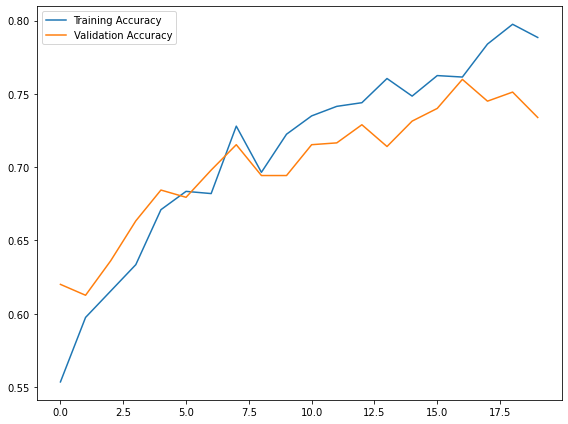

In [91]:
model_history = pd.DataFrame(history3.history)
model_history['epoch'] = history3.epoch
fig, ax = plt.subplots(1, figsize=(8,6))
num_epochs = model_history.shape[0]

ax.plot(np.arange(0, num_epochs), model_history["accuracy"], 
        label="Training Accuracy")
ax.plot(np.arange(0, num_epochs), model_history["val_accuracy"], 
        label="Validation Accuracy")
ax.legend()
plt.tight_layout()
plt.show()

In [73]:
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')
base_model.trainable = False

i = tf.keras.Input(shape=IMG_SHAPE)
x = base_model(i, training = False)
base_model_layer = tf.keras.Model(inputs = [i], outputs = [x])

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 mobilenetv2_1.00_160 (Funct  (None, 5, 5, 1280)       2257984   
 ional)                                                          
                                                                 
Total params: 2,257,984
Trainable params: 0
Non-trainable params: 2,257,984
_________________________________________________________________


In [77]:
model4 = tf.keras.Sequential([
    preprocessor,
    tf.keras.layers.RandomFlip('horizontal'),
    tf.keras.layers.RandomRotation(0.2),
    base_model_layer,
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(num_classes)
])
model4.compile(
  optimizer='adam',
  loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
  metrics=['accuracy'])

history4 = model4.fit(train_dataset, 
                     epochs=20, 
                     validation_data=validation_dataset)

Epoch 1/20
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'arguments' object has no attribute 'posonlyargs'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
63/63 [==============================] - ETA: 0s - loss: 0.4923 - accuracy: 0.9095WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x7f97882a3dd0> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and 

In [ ]:
#My model stabilized between 98-99% accuracy. This is
#much better accuracy than model1. Considering the difference between
#training accuracy(~98%) and validation accuracy(~99%), it is clear
#that there was little overfitting with this model.

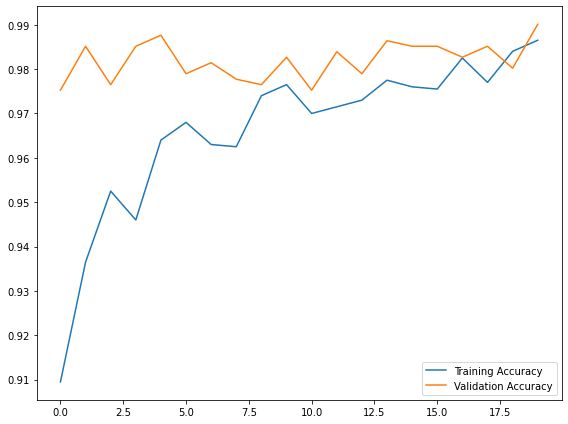

In [84]:
model_history = pd.DataFrame(history4.history)
model_history['epoch'] = history4.epoch
fig, ax = plt.subplots(1, figsize=(8,6))
num_epochs = model_history.shape[0]

ax.plot(np.arange(0, num_epochs), model_history["accuracy"], 
        label="Training Accuracy")
ax.plot(np.arange(0, num_epochs), model_history["val_accuracy"], 
        label="Validation Accuracy")
ax.legend()
plt.tight_layout()
plt.show()

In [87]:
model4.evaluate(test_dataset)

6/6 [==============================] - 3s 417ms/step - loss: 0.0395 - accuracy: 0.9896


[0.039489660412073135, 0.9895833134651184]